In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [132]:
import pandas as pd
import seaborn as sns
import time
import math
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

#### Input params ##################
test_size = 0.2              # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [3]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=N).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=N).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'+str(N)] = mean_list
    df_out[col + '_std'+str(N)] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = np.expm1(est_scaled) 
    y_test =np.expm1(y_test) 
    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [4]:
Final = pd.read_csv('data.csv',parse_dates = ['date'])

In [5]:
Final.head()

,Month,Price,Change,Production,year,Weather,oilPrice,date,goldPrice
0,5,261.48,0.00,60117,2009,64.7,57.30,2009-05-01,926.855
1,6,256.64,-1.85,60117,2009,74.8,68.61,2009-06-01,947.807
2,7,224.85,-12.39,60117,2009,73.5,64.44,2009-07-01,934.272
3,8,210.37,-6.44,60117,2009,74.0,72.51,2009-08-01,949.500
4,9,191.09,-9.16,60117,2009,67.0,67.65,2009-09-01,996.443


In [6]:
gold = Final[['date','Month','year','goldPrice']]
# gold = gold.rename(columns={"goldPrice": "Price"})
wheat = Final[['date','Month','year','Price']]
wheat = wheat.rename(columns={"Price": "wheatPrice"})
oil = Final[['date','Month','year','oilPrice']]
# oil = oil.rename(columns={"oilPrice": "Price"})

In [7]:
gold = get_mov_avg_std(gold,'goldPrice', 2)
gold = get_mov_avg_std(gold,'goldPrice', 4)
gold = get_mov_avg_std(gold,'goldPrice', 6)
gold = gold.drop(columns=['goldPrice'])
gold = gold[6:]
oil = get_mov_avg_std(oil,'oilPrice', 2)
oil = get_mov_avg_std(oil,'oilPrice', 4)
oil = get_mov_avg_std(oil,'oilPrice', 6)
oil = oil.drop(columns=['oilPrice'])
oil = oil[6:]
wheat = wheat[['date','wheatPrice']]
wheat = wheat[6:]

In [8]:
oil.head()

,date,Month,year,oilPrice_mean2,oilPrice_std2,oilPrice_mean4,oilPrice_std4,oilPrice_mean6,oilPrice_std6
6,2009-11-01,11,2009,70.210,3.620387,69.3425,4.028229,67.213333,5.779933
7,2009-12-01,12,2009,74.715,2.750645,72.3975,3.690487,70.440000,4.371160
8,2010-01-01,1,2010,75.560,1.555635,72.8850,3.836218,71.415000,4.530849
9,2010-02-01,2,2010,75.315,1.209153,75.0150,1.769002,73.370000,3.276284
10,2010-03-01,3,2010,74.960,1.711198,75.2600,1.379396,73.576667,3.250192


In [9]:
gold.head()

,date,Month,year,goldPrice_mean2,goldPrice_std2,goldPrice_mean4,goldPrice_std4,goldPrice_mean6,goldPrice_std6
6,2009-11-01,11,2009,1019.9770,33.282102,980.93150,49.402593,966.398000,44.891008
7,2009-12-01,12,2009,1084.8150,58.412677,1028.89325,75.327799,999.608667,74.034414
8,2010-01-01,1,2010,1130.5655,6.288301,1075.27125,66.775887,1030.809500,86.273020
9,2010-02-01,2,2010,1127.2935,10.915607,1106.05425,42.172717,1061.693333,77.526935
10,2010-03-01,3,2010,1107.6875,16.811464,1119.12650,16.788597,1086.076667,54.883089


In [10]:
oil_gold = pd.merge(oil,gold, on=['date','Month','year'])

In [11]:
oil_gold.head()

,date,Month,year,oilPrice_mean2,oilPrice_std2,oilPrice_mean4,oilPrice_std4,oilPrice_mean6,oilPrice_std6,goldPrice_mean2,goldPrice_std2,goldPrice_mean4,goldPrice_std4,goldPrice_mean6,goldPrice_std6
0,2009-11-01,11,2009,70.210,3.620387,69.3425,4.028229,67.213333,5.779933,1019.9770,33.282102,980.93150,49.402593,966.398000,44.891008
1,2009-12-01,12,2009,74.715,2.750645,72.3975,3.690487,70.440000,4.371160,1084.8150,58.412677,1028.89325,75.327799,999.608667,74.034414
2,2010-01-01,1,2010,75.560,1.555635,72.8850,3.836218,71.415000,4.530849,1130.5655,6.288301,1075.27125,66.775887,1030.809500,86.273020
3,2010-02-01,2,2010,75.315,1.209153,75.0150,1.769002,73.370000,3.276284,1127.2935,10.915607,1106.05425,42.172717,1061.693333,77.526935
4,2010-03-01,3,2010,74.960,1.711198,75.2600,1.379396,73.576667,3.250192,1107.6875,16.811464,1119.12650,16.788597,1086.076667,54.883089


In [12]:
wheat.head()

,date,wheatPrice
6,2009-11-01,211.04
7,2009-12-01,206.25
8,2010-01-01,201.19
9,2010-02-01,194.00
10,2010-03-01,191.08


In [13]:
oil_gold.columns

Index(['date', 'Month', 'year', 'oilPrice_mean2', 'oilPrice_std2',
       'oilPrice_mean4', 'oilPrice_std4', 'oilPrice_mean6', 'oilPrice_std6',
       'goldPrice_mean2', 'goldPrice_std2', 'goldPrice_mean4',
       'goldPrice_std4', 'goldPrice_mean6', 'goldPrice_std6'],
      dtype='object')

In [14]:
oil_gold = oil_gold.drop(columns=['date', 'Month', 'year'])


In [15]:
list(oil_gold.iloc[113].values) 

[65.04999999999994,
 1.5414927829838525,
 61.71749999999999,
 4.037312431144208,
 65.44166666666673,
 8.340885844241562,
 1311.0205000000024,
 12.352448360514973,
 1290.8894999999998,
 29.69203399903791,
 1266.5931666666668,
 44.158888371047894]

In [154]:
l = wheat['wheatPrice'].tolist()
dl = wheat['date'].tolist()
step = 3
col = ['oilPrice_mean2', 'oilPrice_std2',
       'oilPrice_mean4', 'oilPrice_std4', 'oilPrice_mean6', 'oilPrice_std6',
       'goldPrice_mean2', 'goldPrice_std2', 'goldPrice_mean4',
       'goldPrice_std4', 'goldPrice_mean6', 'goldPrice_std6','Day','Y','date']

for d in range(len(l)-step+1) :
    day = d+1
    if day == 1 :
        num = range(1,step+1)
        data = pd.DataFrame([list(oil_gold.iloc[day].values) + [i,j,k] for i, j, k in zip(num , l[day:day+step],dl[day:day+step])],columns = col)
    else:
        num = range(1,step+1)
        temp = pd.DataFrame([list(oil_gold.iloc[day].values) + [i,j,k] for i, j, k in zip(num , l[day:day+step],dl[day:day+step])],columns = col)
        data = pd.concat([data,temp],axis = 0)
df = data 
df.head()

,oilPrice_mean2,oilPrice_std2,oilPrice_mean4,oilPrice_std4,oilPrice_mean6,oilPrice_std6,goldPrice_mean2,goldPrice_std2,goldPrice_mean4,goldPrice_std4,goldPrice_mean6,goldPrice_std6,Day,Y,date
0,74.715,2.750645,72.3975,3.690487,70.440,4.371160,1084.8150,58.412677,1028.89325,75.327799,999.608667,74.034414,1,206.25,2009-12-01
1,74.715,2.750645,72.3975,3.690487,70.440,4.371160,1084.8150,58.412677,1028.89325,75.327799,999.608667,74.034414,2,201.19,2010-01-01
2,74.715,2.750645,72.3975,3.690487,70.440,4.371160,1084.8150,58.412677,1028.89325,75.327799,999.608667,74.034414,3,194.00,2010-02-01
0,75.560,1.555635,72.8850,3.836218,71.415,4.530849,1130.5655,6.288301,1075.27125,66.775887,1030.809500,86.273020,1,201.19,2010-01-01
1,75.560,1.555635,72.8850,3.836218,71.415,4.530849,1130.5655,6.288301,1075.27125,66.775887,1030.809500,86.273020,2,194.00,2010-02-01


In [156]:
col = ['oilPrice_mean2', 'oilPrice_std2', 'oilPrice_mean4', 'oilPrice_std4',
       'oilPrice_mean6', 'oilPrice_std6', 'goldPrice_mean2', 'goldPrice_std2',
       'goldPrice_mean4', 'goldPrice_std4', 'goldPrice_mean6',
       'goldPrice_std6', 'Day']

In [157]:
df ,df_y = df.drop(columns = ['Y','date'],axis=1) ,df[['Y','date']] 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns = col)
df = pd.concat([df,df_y.reset_index()],axis = 1)
df = df.drop(columns = ['index'],axis=1)

# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))
train_cv.head()

train.shape = (201, 15)
cv.shape = (67, 15)
train_cv.shape = (268, 15)
test.shape = (67, 15)


,oilPrice_mean2,oilPrice_std2,oilPrice_mean4,oilPrice_std4,oilPrice_mean6,oilPrice_std6,goldPrice_mean2,goldPrice_std2,goldPrice_mean4,goldPrice_std4,goldPrice_mean6,goldPrice_std6,Day,Y,date
0,0.474715,0.220189,0.447727,0.179600,0.421550,0.162241,0.009343,0.430866,0.000000,0.568173,0.000000,0.483350,0.0,206.25,2009-12-01
1,0.474715,0.220189,0.447727,0.179600,0.421550,0.162241,0.009343,0.430866,0.000000,0.568173,0.000000,0.483350,0.5,201.19,2010-01-01
2,0.474715,0.220189,0.447727,0.179600,0.421550,0.162241,0.009343,0.430866,0.000000,0.568173,0.000000,0.483350,1.0,194.00,2010-02-01
3,0.483984,0.120425,0.453529,0.188111,0.434024,0.170385,0.075483,0.043717,0.065588,0.499733,0.043995,0.584184,0.0,201.19,2010-01-01
4,0.483984,0.120425,0.453529,0.188111,0.434024,0.170385,0.075483,0.043717,0.065588,0.499733,0.043995,0.584184,0.5,194.00,2010-02-01


In [158]:
train.columns

Index(['oilPrice_mean2', 'oilPrice_std2', 'oilPrice_mean4', 'oilPrice_std4',
       'oilPrice_mean6', 'oilPrice_std6', 'goldPrice_mean2', 'goldPrice_std2',
       'goldPrice_mean4', 'goldPrice_std4', 'goldPrice_mean6',
       'goldPrice_std6', 'Day', 'Y', 'date'],
      dtype='object')

In [190]:
features = ['oilPrice_mean2', 'oilPrice_std2', 'oilPrice_mean4', 'oilPrice_std4',
       'oilPrice_mean6', 'oilPrice_std6', 'goldPrice_mean2', 'goldPrice_std2',
       'goldPrice_mean4', 'goldPrice_std4', 'goldPrice_mean6',
       'goldPrice_std6', 'Day']


target = 'Y'


# Split into X and y

X_train = train[features]
y_train = train[target]
y_train = np.log1p(y_train)

X_cv = cv[features]
y_cv = cv[target]
y_cv = np.log1p(y_cv)

X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
y_train_cv = np.log1p(y_train_cv)

X_sample = test[features]
y_sample = test[target]
y_sample = np.log1p(y_sample)

print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (201, 13)
y_train.shape = (201,)
X_cv.shape = (67, 13)
y_cv.shape = (67,)
X_train_cv.shape = (268, 13)
y_train_cv.shape = (268,)
X_sample.shape = (67, 13)
y_sample.shape = (67,)


Text(0.5, 1.0, 'Without scaling')

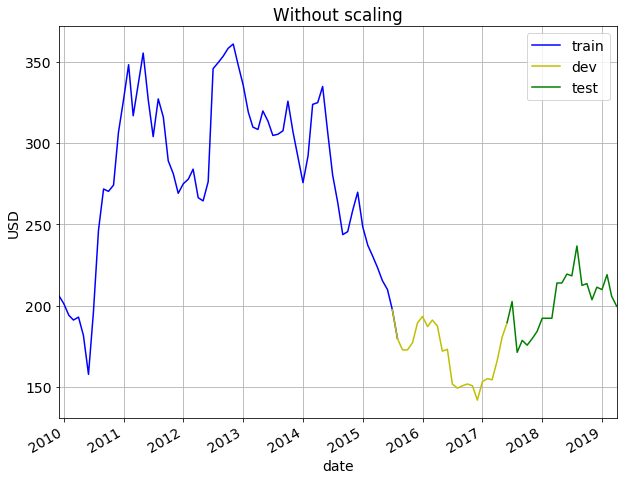

In [191]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='Y', style='b-', grid=True)
ax = cv.plot(x='date', y='Y', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Y', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

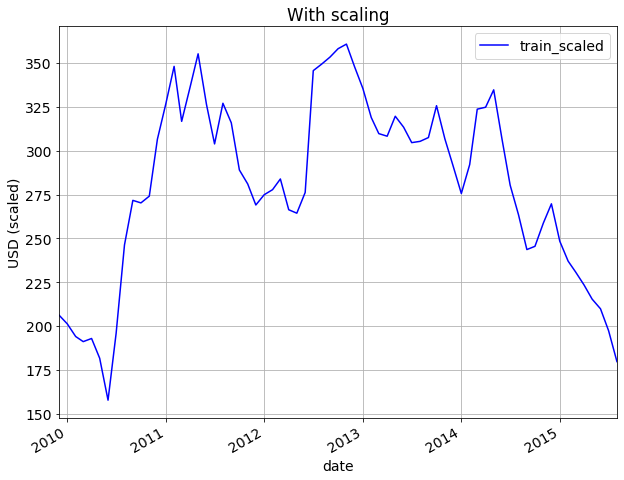

In [192]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='Y', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [193]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train, y_train)

[17:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

In [194]:
train.columns

Index(['oilPrice_mean2', 'oilPrice_std2', 'oilPrice_mean4', 'oilPrice_std4',
       'oilPrice_mean6', 'oilPrice_std6', 'goldPrice_mean2', 'goldPrice_std2',
       'goldPrice_mean4', 'goldPrice_std4', 'goldPrice_mean6',
       'goldPrice_std6', 'Day', 'Y', 'date'],
      dtype='object')

In [195]:
# Do prediction on train set
est_scaled = model.predict(X_train)
est = np.expm1(est_scaled)
y_train = np.expm1(y_train)
# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))
# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))
y_train = np.log1p(y_train)

RMSE on train set = 12.043
MAPE on train set = 3.225%


Text(0.5, 1.0, 'Without scaling')

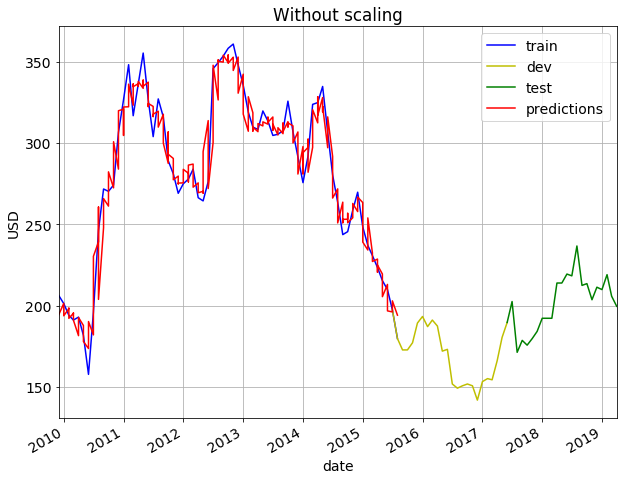

In [196]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='Y', style='b-', grid=True)
ax = cv.plot(x='date', y='Y', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Y', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [197]:
est_scaled

array([5.2742977, 5.3101125, 5.293999 , 5.2714396, 5.2952576, 5.2791443,
       5.263356 , 5.280405 , 5.266121 , 5.257228 , 5.262391 , 5.2403784,
       5.2066345, 5.194614 , 5.1623335, 5.1866965, 5.1730866, 5.2092056,
       5.253076 , 5.2858477, 5.3219666, 5.4436345, 5.4811397, 5.5172586,
       5.566842 , 5.567226 , 5.56893  , 5.5864787, 5.609047 , 5.610878 ,
       5.646241 , 5.6486607, 5.652194 , 5.70963  , 5.7188187, 5.722352 ,
       5.770849 , 5.7780023, 5.778378 , 5.7738795, 5.7810326, 5.7814083,
       5.8205457, 5.8209295, 5.8213053, 5.8160076, 5.8163915, 5.816767 ,
       5.8255067, 5.827926 , 5.8241467, 5.8129163, 5.7787013, 5.779077 ,
       5.784735 , 5.75961  , 5.7699323, 5.764212 , 5.76329  , 5.764045 ,
       5.7389655, 5.7380433, 5.729335 , 5.7066007, 5.68363  , 5.6749215,
       5.664448 , 5.6508994, 5.6369195, 5.6289263, 5.6197524, 5.6219573,
       5.6214986, 5.62198  , 5.624185 , 5.65164  , 5.660753 , 5.6629577,
       5.643183 , 5.6491237, 5.621923 , 5.6124043, 

RMSE on dev set = 78.119
MAPE on dev set = 38.927%


Text(0, 0.5, 'USD')

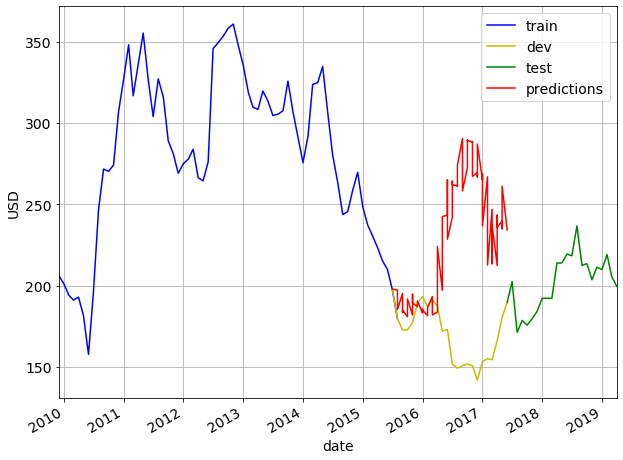

In [198]:
# Do prediction on test set
est_scaled = model.predict(X_cv)
cv['est_scaled'] = est_scaled
cv['est'] = np.expm1(cv['est_scaled']) 

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(np.expm1(y_cv), cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(np.expm1(y_cv), cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='Y', style='b-', grid=True)
ax = cv.plot(x='date', y='Y', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Y', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

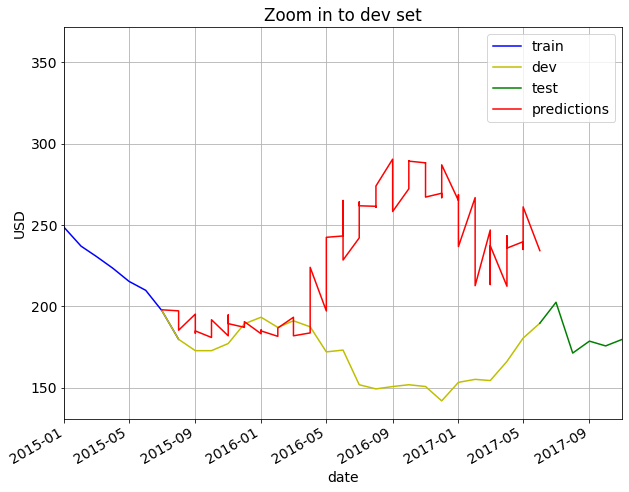

In [199]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='Y', style='b-', grid=True)
ax = cv.plot(x='date', y='Y', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Y', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2015, 1, 1), date(2017, 11, 1)])
ax.set_title("Zoom in to dev set")

# Features importance

In [202]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('oilPrice_std4', 0.01715043),
 ('oilPrice_std2', 0.026101694),
 ('oilPrice_std6', 0.027813949),
 ('oilPrice_mean2', 0.037487797),
 ('goldPrice_std6', 0.057040766),
 ('goldPrice_mean6', 0.0664612),
 ('oilPrice_mean4', 0.10019155),
 ('oilPrice_mean6', 0.11749678),
 ('goldPrice_mean2', 0.21984945),
 ('goldPrice_mean4', 0.2985357)]

In [203]:
y_cv

201    5.289831
202    5.196728
203    5.157330
204    5.196728
205    5.157330
206    5.157387
207    5.157330
208    5.157387
209    5.182345
210    5.157387
211    5.182345
212    5.248234
213    5.182345
214    5.248234
215    5.269249
216    5.248234
217    5.269249
218    5.236602
219    5.269249
220    5.236602
221    5.257860
222    5.236602
223    5.257860
224    5.238514
225    5.257860
226    5.238514
227    5.153060
228    5.238514
229    5.153060
230    5.159400
         ...   
238    5.011835
239    5.021575
240    5.011835
241    5.021575
242    5.028803
243    5.021575
244    5.028803
245    5.021575
246    5.028803
247    5.021575
248    4.961655
249    5.021575
250    4.961655
251    5.038380
252    4.961655
253    5.038380
254    5.050241
255    5.038380
256    5.050241
257    5.045488
258    5.050241
259    5.045488
260    5.118473
261    5.045488
262    5.118473
263    5.200760
264    5.118473
265    5.200760
266    5.250177
267    5.200760
Name: Y, Length: 67, dty

In [204]:
param_label = 'n_estimators'
param_list = range(1, 30, 1)

param2_label = 'max_depth'
param2_list = [6, 7, 8, 9,10,11,12,13,14]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train, 
                                     y_train, 
                                     X_cv, 
                                     y_cv, 
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Minutes taken = 0.029335399468739826


,n_estimators,max_depth,rmse,mape_pct
0,1,6,167.817138,98.954880
1,1,7,167.817138,98.954880
2,1,8,167.817138,98.954880
3,1,9,167.817138,98.954880
4,1,10,167.817138,98.954880
5,1,11,167.817138,98.954880
6,1,12,167.817138,98.954880
7,1,13,167.817138,98.954880
8,1,14,167.817138,98.954880
9,2,6,166.221011,97.995593


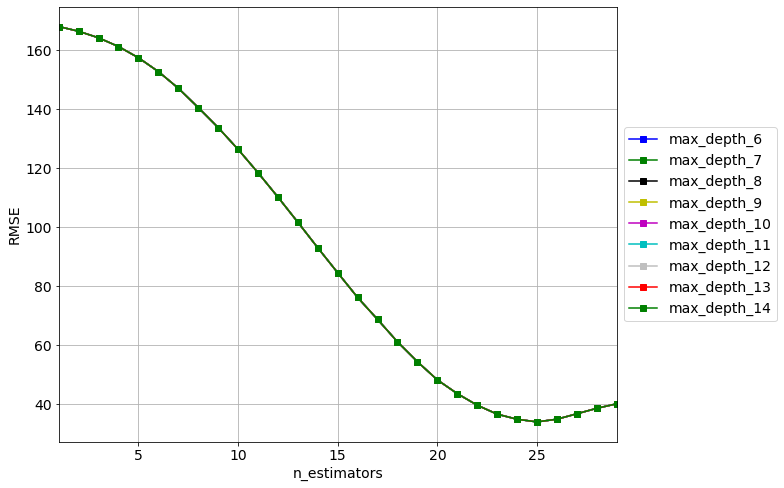

In [205]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [206]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 33.794
optimum params = 


(25, 6)

In [207]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 18.017%
optimum params = 


(25, 6)

In [208]:
param_label = 'learning_rate'
param_list = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]

param2_label = 'min_child_weight'
param2_list = range(10, 41, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train, 
                                     y_train, 
                                     X_cv, 
                                     y_cv, 
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,learning_rate,min_child_weight,rmse,mape_pct
0,0.005,10,167.556759,98.798396
1,0.005,11,167.556759,98.798396
2,0.005,12,167.556759,98.798396
3,0.005,13,167.556759,98.798396
4,0.005,14,167.556759,98.798396
5,0.005,15,167.556759,98.798396
6,0.005,16,167.556759,98.798396
7,0.005,17,167.556759,98.798396
8,0.005,18,167.556759,98.798396
9,0.005,19,167.556759,98.798396


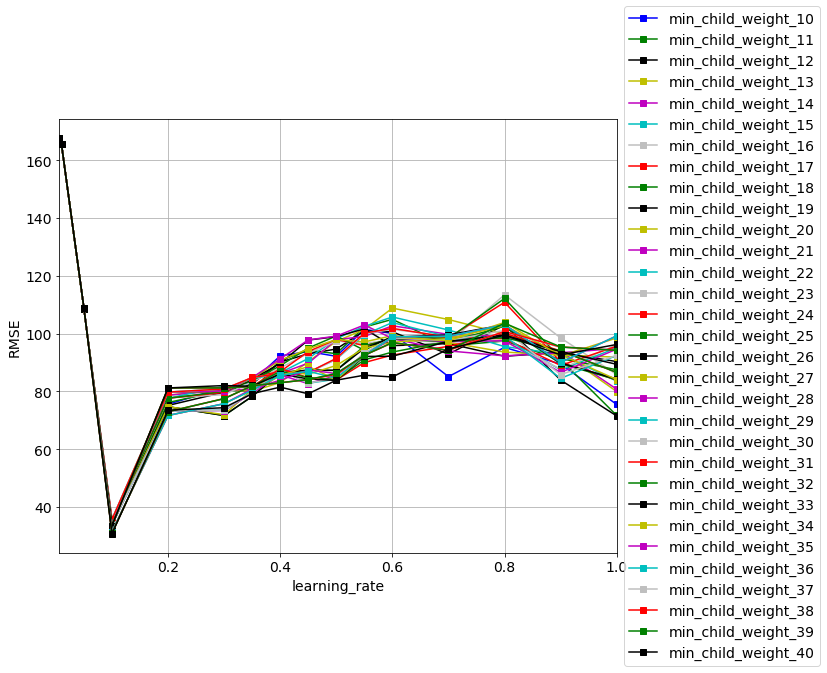

In [209]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [210]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 30.748
optimum params = 


(0.1, 40)

In [211]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 16.516%
optimum params = 


(0.1, 37)

In [212]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train, 
                                     y_train, 
                                     X_cv, 
                                     y_cv, 
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,subsample,gamma,rmse,mape_pct
0,0.1,0.1,21.164524,11.080946
1,0.1,0.2,21.164524,11.080946
2,0.1,0.3,21.164524,11.080946
3,0.1,0.4,21.164524,11.080946
4,0.1,0.5,21.164524,11.080946
5,0.1,0.6,21.164524,11.080946
6,0.1,0.7,21.164524,11.080946
7,0.1,0.8,21.164524,11.080946
8,0.1,0.9,21.164524,11.080946
9,0.1,1.0,21.164524,11.080946


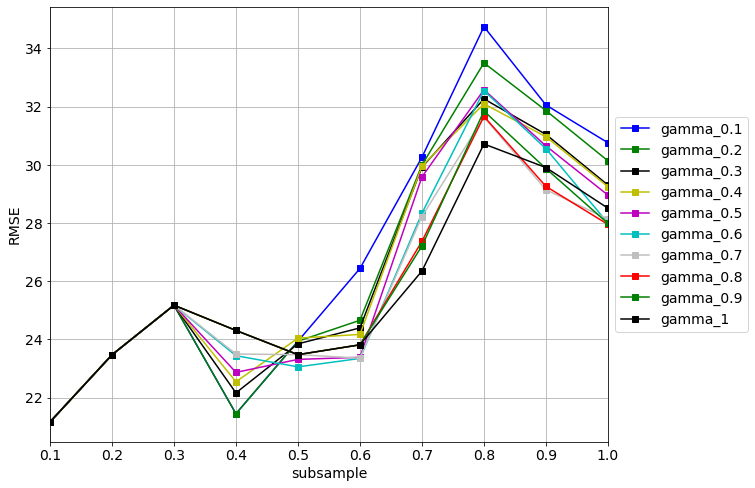

In [213]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [214]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 21.165
optimum params = 


(0.1, 0.1)

In [215]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 10.871%
optimum params = 


(0.4, 0.1)

In [216]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train, 
                                     y_train, 
                                     X_cv, 
                                     y_cv, 
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,21.164524,11.080946
1,0.5,0.6,21.164524,11.080946
2,0.5,0.7,21.164524,11.080946
3,0.5,0.8,21.164524,11.080946
4,0.5,0.9,21.164524,11.080946
5,0.5,1.0,21.164524,11.080946
6,0.6,0.5,21.164524,11.080946
7,0.6,0.6,21.164524,11.080946
8,0.6,0.7,21.164524,11.080946
9,0.6,0.8,21.164524,11.080946


In [217]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,25.000
1,max_depth,3.000,6.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,40.000
4,subsample,1.000,0.100
5,gamma,0.000,0.100
6,rmse,78.119,21.165
7,mape_pct,38.927,11.081


In [218]:
y_cv

201    5.289831
202    5.196728
203    5.157330
204    5.196728
205    5.157330
206    5.157387
207    5.157330
208    5.157387
209    5.182345
210    5.157387
211    5.182345
212    5.248234
213    5.182345
214    5.248234
215    5.269249
216    5.248234
217    5.269249
218    5.236602
219    5.269249
220    5.236602
221    5.257860
222    5.236602
223    5.257860
224    5.238514
225    5.257860
226    5.238514
227    5.153060
228    5.238514
229    5.153060
230    5.159400
         ...   
238    5.011835
239    5.021575
240    5.011835
241    5.021575
242    5.028803
243    5.021575
244    5.028803
245    5.021575
246    5.028803
247    5.021575
248    4.961655
249    5.021575
250    4.961655
251    5.038380
252    4.961655
253    5.038380
254    5.050241
255    5.038380
256    5.050241
257    5.045488
258    5.050241
259    5.045488
260    5.118473
261    5.045488
262    5.118473
263    5.200760
264    5.118473
265    5.200760
266    5.250177
267    5.200760
Name: Y, Length: 67, dty

In [219]:
y_train

0      5.333926
1      5.309208
2      5.273000
3      5.309208
4      5.273000
5      5.257912
6      5.273000
7      5.257912
8      5.267188
9      5.257912
10     5.267188
11     5.207353
12     5.267188
13     5.207353
14     5.066827
15     5.207353
16     5.066827
17     5.282290
18     5.066827
19     5.282290
20     5.510400
21     5.282290
22     5.510400
23     5.608262
24     5.510400
25     5.608262
26     5.602967
27     5.608262
28     5.602967
29     5.617062
         ...   
171    5.499665
172    5.507159
173    5.559450
174    5.507159
175    5.559450
176    5.601011
177    5.559450
178    5.601011
179    5.519018
180    5.601011
181    5.519018
182    5.472271
183    5.519018
184    5.472271
185    5.445659
186    5.472271
187    5.445659
188    5.413430
189    5.445659
190    5.413430
191    5.376759
192    5.413430
193    5.376759
194    5.350957
195    5.376759
196    5.350957
197    5.289831
198    5.350957
199    5.289831
200    5.196728
Name: Y, Length: 201, dt

In [220]:
est_scaled

array([5.292566 , 5.2892237, 5.279119 , 5.2273483, 5.2173634, 5.203079 ,
       5.2249136, 5.2247787, 5.2086654, 5.2612505, 5.276375 , 5.255132 ,
       5.248782 , 5.2367616, 5.215519 , 5.2381   , 5.228115 , 5.2068725,
       5.2249136, 5.2247787, 5.2086654, 5.234565 , 5.23443  , 5.2183166,
       5.2691107, 5.3049254, 5.288812 , 5.415957 , 5.4517717, 5.4356585,
       5.4947863, 5.4982133, 5.493238 , 5.583712 , 5.58037  , 5.5702653,
       5.571395 , 5.568053 , 5.557948 , 5.616687 , 5.6153803, 5.610405 ,
       5.6750445, 5.6717024, 5.6672277, 5.67079  , 5.667448 , 5.6629734,
       5.5915785, 5.590272 , 5.583666 , 5.6003747, 5.5970325, 5.5904264,
       5.4711976, 5.4766603, 5.473514 , 5.364362 , 5.367789 , 5.3628135,
       5.5130963, 5.498447 , 5.4835715, 5.4670343, 5.463692 , 5.460546 ,
       5.5688744], dtype=float32)

In [221]:
X_cv

,oilPrice_mean2,oilPrice_std2,oilPrice_mean4,oilPrice_std4,oilPrice_mean6,oilPrice_std6,goldPrice_mean2,goldPrice_std2,goldPrice_mean4,goldPrice_std4,goldPrice_mean6,goldPrice_std6,Day
201,0.343791,0.144038,0.303076,0.165602,0.259894,0.228242,0.161356,0.078081,0.227421,0.041899,0.291786,0.101785,0.0
202,0.343791,0.144038,0.303076,0.165602,0.259894,0.228242,0.161356,0.078081,0.227421,0.041899,0.291786,0.101785,0.5
203,0.343791,0.144038,0.303076,0.165602,0.259894,0.228242,0.161356,0.078081,0.227421,0.041899,0.291786,0.101785,1.0
204,0.302545,0.280992,0.305070,0.149454,0.278659,0.097691,0.113574,0.263118,0.210077,0.217108,0.264113,0.142129,0.0
205,0.302545,0.280992,0.305070,0.149454,0.278659,0.097691,0.113574,0.263118,0.210077,0.217108,0.264113,0.142129,0.5
206,0.302545,0.280992,0.305070,0.149454,0.278659,0.097691,0.113574,0.263118,0.210077,0.217108,0.264113,0.142129,1.0
207,0.220491,0.583235,0.266393,0.416595,0.253966,0.251291,0.066790,0.070828,0.181536,0.275175,0.237422,0.159576,0.0
208,0.220491,0.583235,0.266393,0.416595,0.253966,0.251291,0.066790,0.070828,0.181536,0.275175,0.237422,0.159576,0.5
209,0.220491,0.583235,0.266393,0.416595,0.253966,0.251291,0.066790,0.070828,0.181536,0.275175,0.237422,0.159576,1.0
210,0.171457,0.055490,0.217422,0.384548,0.236331,0.312768,0.061965,0.035771,0.155805,0.200265,0.224325,0.186282,0.0


[17:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on dev set = 30.755
MAPE on dev set = 16.799%


Text(0, 0.5, 'USD')

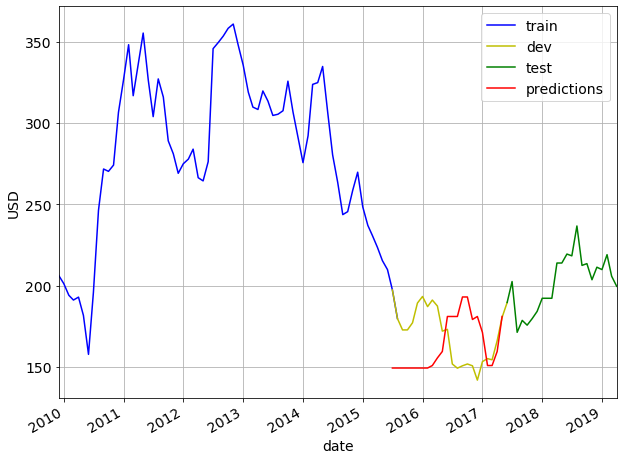

In [222]:
# Create the model
model = XGBRegressor(seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample, 
                             gamma=gamma_opt)

# Train the regressor
model.fit(X_train, y_train)
# Do prediction on test set
est_scaled = model.predict(X_cv)
cv['est_scaled'] = est_scaled
cv['est'] = np.expm1(cv['est_scaled']) 
# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(np.expm1(y_cv), cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(np.expm1(y_cv), cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': np.expm1(y_cv),
                       'date': cv['date']}).iloc[::3]

ax = train.plot(x='date', y='Y', style='b-', grid=True)
ax = cv.plot(x='date', y='Y', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Y', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [223]:
est_scaled

array([5.0124493, 5.0124493, 5.0124493, 5.0124493, 5.0124493, 5.0124493,
       5.0124493, 5.0124493, 5.0124493, 5.0124493, 5.0124493, 5.0124493,
       5.0124493, 5.0124493, 5.0124493, 5.0124493, 5.0124493, 5.0124493,
       5.0124493, 5.0124493, 5.0124493, 5.0124493, 5.0124493, 5.0124493,
       5.0225906, 5.0225906, 5.0225906, 5.0529675, 5.0529675, 5.0529675,
       5.07801  , 5.07801  , 5.07801  , 5.203837 , 5.203837 , 5.203837 ,
       5.203837 , 5.203837 , 5.203837 , 5.203837 , 5.203837 , 5.203837 ,
       5.267693 , 5.267693 , 5.267693 , 5.267693 , 5.267693 , 5.267693 ,
       5.1936955, 5.1936955, 5.1936955, 5.203837 , 5.203837 , 5.203837 ,
       5.1484175, 5.1484175, 5.1484175, 5.0225906, 5.0225906, 5.0225906,
       5.0225906, 5.0225906, 5.0225906, 5.07801  , 5.07801  , 5.07801  ,
       5.203837 ], dtype=float32)

In [235]:
new_test = X_sample.head(1)
new_test.columns
new_test = new_test.drop('Day',axis = 1)

In [236]:
temp2 = new_test 
for i in range(step-1) :
    temp2 = pd.concat([temp2,new_test], axis = 0)
temp2['Day'] = list(range(1,step+1))
new_test = temp2

In [242]:
rmse, mape, est = train_pred_eval_model(X_train_cv, 
                             y_train_cv, 
                             new_test, 
                             y_sample.iloc[:3],        
                             seed=model_seed,
                             n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             learning_rate=learning_rate, 
                             min_child_weight=min_child_weight, 
                             subsample=subsample, 
                             gamma=gamma)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

[17:36:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set = 12.117
MAPE on test set = 5.321%


In [243]:
est

array([183.39508, 183.39508, 183.39508], dtype=float32)

In [244]:
est[::3]

array([183.39508], dtype=float32)

In [245]:
list(range(1,step+1))

[1, 2, 3]

Text(0, 0.5, 'USD')

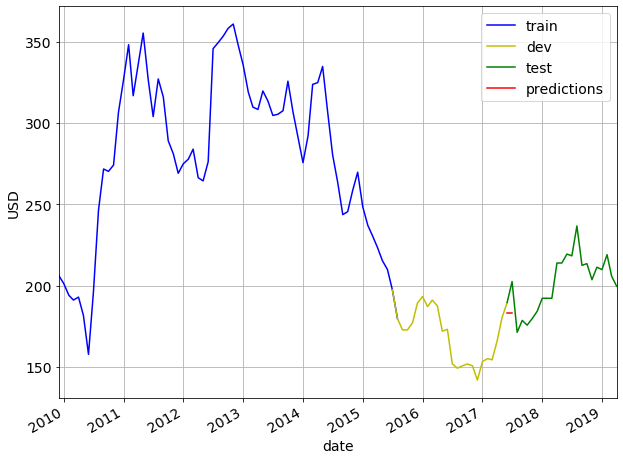

In [246]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample.iloc[:3],
                       'date': test['date'].iloc[:3]})

ax = train.plot(x='date', y='Y', style='b-', grid=True)
ax = cv.plot(x='date', y='Y', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Y', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [231]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])
ax.set_ylim([160, 250])
ax.set_title("Zoom in to test set")

KeyError: 'wheatPrice'

In [232]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('oilPrice_std4', 0.0),
 ('oilPrice_std6', 0.0),
 ('goldPrice_std2', 0.0),
 ('goldPrice_std4', 0.0),
 ('goldPrice_mean6', 0.0),
 ('Day', 0.0),
 ('goldPrice_std6', 0.17831594),
 ('oilPrice_mean6', 0.2095809),
 ('goldPrice_mean2', 0.21049948),
 ('goldPrice_mean4', 0.40160367)]

In [233]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='wheatPrice', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])

KeyError: 'wheatPrice'

In [234]:
rmse,mape

(117.67681598536043, 60.76678820960827)

In [ ]:
from sklearn.linear_model import Lasso
lasso_opt = Lasso(alpha =55 ,max_iter = 1000)
lasso_opt.fit(X_train, y_train)
est = lasso_opt.predict(X_sample)
rmse = math.sqrt(mean_squared_error(y_sample, est))
mape = get_mape(y_sample, est)
rmse,mape

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='wheatPrice', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lasso'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])

In [ ]:
from sklearn.linear_model import Lasso
lasso_opt = Lasso(alpha =55 ,max_iter = 1000)
lasso_opt.fit(X_train, y_train)
est = lasso_opt.predict(X_cv)
rmse = math.sqrt(mean_squared_error(y_cv, est))
mape = get_mape(y_cv, est)
rmse,mape

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = cv.plot(x='date', y='wheatPrice', style='yx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['cv', 'predictions using lasso'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2015, 3, 1), date(2017, 7, 1)])

In [ ]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train)
est = regr.predict(X_sample)
rmse = math.sqrt(mean_squared_error(y_sample, est))
mape = get_mape(y_sample, est)
rmse,mape

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
fig, (ax1, ax2) = plt.subplots(2,1)
est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax1 = train.plot(x='date', y='wheatPrice', style='b-', grid=True ,ax=ax1)
ax1 = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax1)
ax1 = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax1)
ax1 = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax1)
ax1.legend(['train', 'dev', 'test', 'predictions'])
ax1.set_xlabel("date")
ax1.set_ylabel("USD")

rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax2 = test.plot(x='date', y='wheatPrice', style='gx-', grid=True, ax=ax2)
ax2 = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax2)
ax2.legend(['test', 'predictions using lasso'], loc='upper left')
ax2.set_xlabel("date")
ax2.set_ylabel("USD")
ax2.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])



In [ ]:
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          alpha=1, \
                          max_iter=1000, \
                          l1_ratio=0.5):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,max_iter=max_iter,random_state=0)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [ ]:
param_label = 'alpha'
param_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

param2_label = 'l1_ratio'
param2_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]



error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Price_mean'],
                                     cv['Price_std'],
                                     alpha=param, 
                                     l1_ratio=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Price_mean'],
                                     cv['Price_std'],
                                     alpha=1, 
                                     max_iter=1000,
                                     l1_ratio=1)
rmse, mape